In [ ]:
! pip install kaggle

In [ ]:
# === Gerekli Kütüphaneler ===
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2


In [ ]:
import os
import kagglehub

# Download latest version
downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to downloaded dataset files:", downloaded_path)

# Veri seti yolu: kagglehub tarafından indirilen path'i kullan
# İndirilen path'in içindeki 'Dataset - train+val+test' klasörüne işaret etmesi gerekiyor.
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Sınıf sayımlarını hesaplayan fonksiyon
def count_images_in_folder(folder_path):
    """Verilen klasördeki sınıfların görsel sayılarını hesaplar."""
    class_counts = {}
    # Check if the folder_path exists before listing
    if not os.path.exists(folder_path):
        print(f"Hata: Klasör bulunamadı: {folder_path}")
        return class_counts # Return empty if folder doesn't exist

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([name for name in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, name))])
            class_counts[class_name] = num_images
    return class_counts

# Klasörleri tara ve sınıf sayılarını yazdır
for folder in ['train', 'val', 'test']:
    folder_path = os.path.join(dataset_path, folder)
    print(f"\n'{folder}' klasöründeki içerikler:")

    class_counts = count_images_in_folder(folder_path)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} görsel")

Path to downloaded dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2

'train' klasöründeki içerikler:
  DRUSEN: 6206 görsel
  CNV: 26218 görsel
  NORMAL: 35973 görsel
  DME: 8118 görsel

'val' klasöründeki içerikler:
  DRUSEN: 1773 görsel
  CNV: 7491 görsel
  NORMAL: 10278 görsel
  DME: 2319 görsel

'test' klasöründeki içerikler:
  DRUSEN: 887 görsel
  CNV: 3746 görsel
  NORMAL: 5139 görsel
  DME: 1161 görsel


kütüphaneler

In [ ]:
# === Veri yolu ===
# dataset_path = "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test" # Remove this hardcoded path

# Use the path obtained from kagglehub.dataset_download
# downloaded_path is defined in the previous cell
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")


# === Dataset yükle ===
def load_datasets():
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    return train_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           val_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           test_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Call the load_datasets function and assign the returned values
train_dataset, val_dataset, test_dataset = load_datasets()

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


In [ ]:
# === Callback ===
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# === Model 1: MobileNetV2 ===
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet.trainable = False

x1 = base_mobilenet.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(128, activation='relu')(x1)
out1 = Dense(4, activation='softmax')(x1)

mobilenet_model = Model(inputs=base_mobilenet.input, outputs=out1)
mobilenet_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("📦 MobileNetV2 Model Eğitimi Başladı")
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stop]
)

mobilenet_model.save('/content/drive/MyDrive/mobilenet_model.keras')


📦 MobileNetV2 Model Eğitimi Başladı


NameError: name 'train_dataset' is not defined

In [ ]:
# === Sınıf ağırlıklarını hesapla ===
def compute_class_weights():
    class_counts = {'DRUSEN': 6206, 'CNV': 26218, 'NORMAL': 35973, 'DME': 8118}
    total = sum(class_counts.values())
    return {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts.values())}

In [ ]:
# Modeli oluştur
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# İlk 140 katmanı dondur
for layer in base_model.layers[:140]:
    layer.trainable = False

In [ ]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Modeli eğit
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

NameError: name 'train_dataset' is not defined

In [ ]:
model.save('modelim.keras')

In [ ]:
# Mimariyi JSON olarak kaydet
model_json = model.to_json()
with open("modelim.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving modelim.keras to modelim.keras


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Kendi kaydettiğin isimle yükle
model = tf.keras.models.load_model("modelim.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Modeli kullanarak tahminler yapın
y_pred = model.predict(test_dataset)

# Yalnızca sınıf tahminleri almak için softmax çıkışını argmax ile sınıf etiketlerine dönüştürün
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketlerinizi de sınıf etiketlerine dönüştürün
# Burada gerçek etiketler için test_labels değişkeni kullanılmış,
# ancak load_datasets fonksiyonu sadece dataset objeleri döndürüyor.
# Gerçek etiketlere erişmek için test_dataset'in etiketlerini almanız gerekecek.
# Bu, .unbatch() ve iterasyon gerektirebilir veya farklı bir yaklaşım
# Eğer sadece metrikleri hesaplamak istiyorsanız, test_dataset'in etiketlerini
# ayıklamanız gerekmektedir. Aşağıdaki kısım, test_dataset'ten etiketleri çıkarmanın
# bir yolunu gösterir.

y_true_classes = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)


# F1-score, recall ve precision hesaplamak
# sklearn.metrics'ten ilgili fonksiyonları içe aktarmayı unutmayın
from sklearn.metrics import f1_score, recall_score, precision_score

f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

print("F1-Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

171/171 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step
F1-Score: 0.9285113413717231
Recall: 0.9360651239367054
Precision: 0.9374431267466613


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score


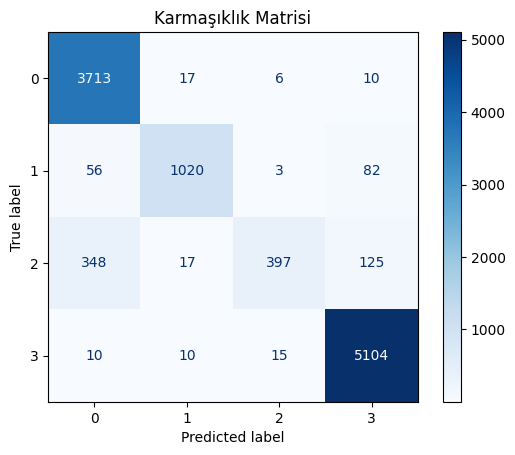

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = list(range(len(cm)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Karmaşıklık Matrisi")
plt.show()

In [ ]:
import pickle

# Kaydetme
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Yükleme
with open('history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Sonra aynı çizimleri history_data['accuracy'] gibi kullanarak yapabilirsin.


NameError: name 'history' is not defined

In [ ]:
# Accuracy grafiği
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu (Accuracy)')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu (Val Accuracy)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss grafiği
plt.plot(history.history['loss'], label='Eğitim Kaybı (Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (Val Loss)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

In [ ]:
# === Sınıf ağırlıklarını hesapla ===
def compute_class_weights():
    class_counts = {'DRUSEN': 6206, 'CNV': 26218, 'NORMAL': 35973, 'DME': 8118}
    total = sum(class_counts.values())
    return {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts.values())}

In [ ]:
# === Model oluşturucu ===
def build_model(model_type="MobileNetV2"):
    if model_type == "MobileNetV2":
        base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    else:
        raise ValueError("Desteklenmeyen model")

    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs=base.input, outputs=output)